In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf

2025-12-02 12:07:50.572893: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 12:07:50.594732: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-02 12:07:50.667179: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-02 12:07:50.667226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-02 12:07:50.668722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Data Loading

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

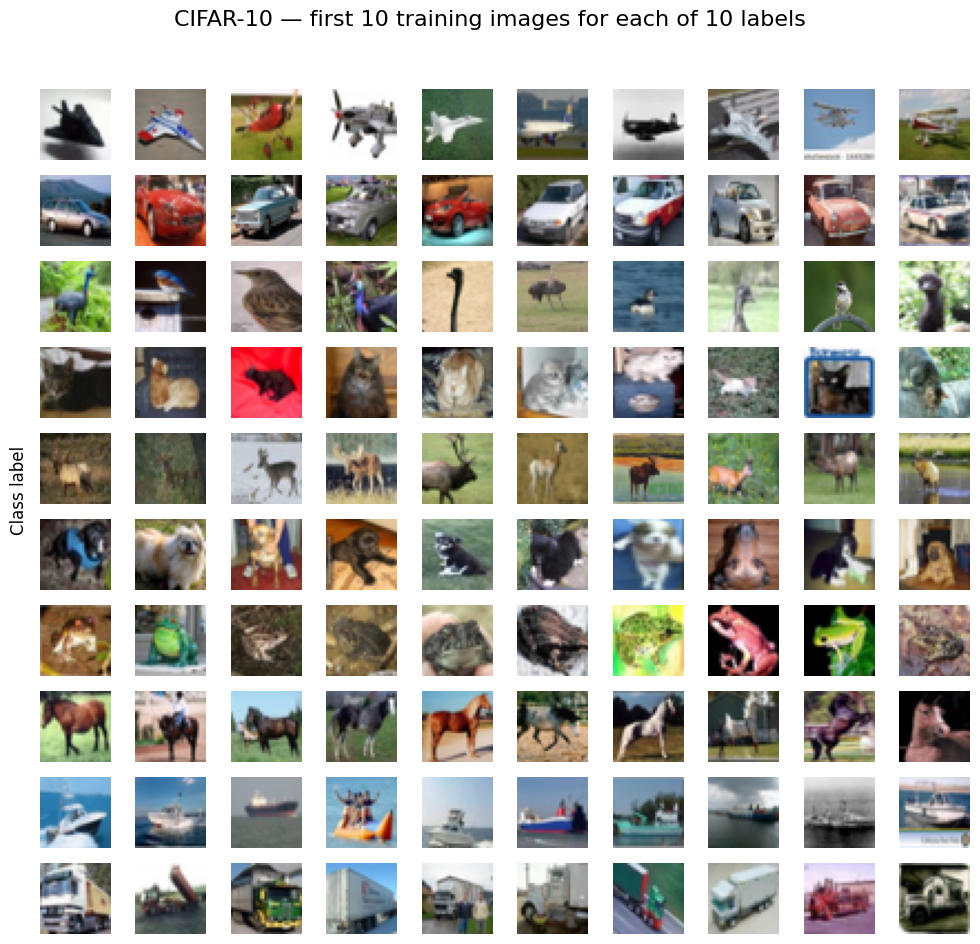

In [3]:
# pick the first 10 distinct labels that appear in x_test
labels_to_plot = np.unique(y_test.ravel())[:10]
if labels_to_plot.size < 10:
    raise RuntimeError("Less than 10 distinct labels found in y_test.")

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10), squeeze=False)
for row, label in enumerate(labels_to_plot):
    # find first 10 indices in x_train with this label
    idxs = np.where(y_train.ravel() == label)[0][:10]
    for col in range(10):
        ax = axes[row, col]
        ax.axis("off")
        if col < len(idxs):
            ax.imshow(x_train[idxs[col]])
    # label the row with the class id on the leftmost subplot
    axes[row, 0].set_ylabel(str(int(label)), rotation=0, fontsize=12, labelpad=40, va="center")

# figure title and axis labels
fig.suptitle("CIFAR-10 — first 10 training images for each of 10 labels", fontsize=16)
fig.text(0.02, 0.5, "Class label", va="center", rotation="vertical", fontsize=12)

plt.tight_layout(rect=[0.03, 0.04, 1, 0.95])
plt.show()

## Base Model

Just going to use a basic CNN with a couple of layers, goal is to get >70% accuracy for this initial run.

In [4]:
# build a simple CNN (4 convolutional layers) for CIFAR-10
# uses already-loaded numpy arrays: x_train, y_train, x_test, y_test

# normalize copies of the data (don't overwrite originals)
x_train_norm = x_train.astype("float32") / 255.0
x_test_norm  = x_test.astype("float32")  / 255.0
y_train_flat = y_train.ravel()
y_test_flat  = y_test.ravel()

model = keras.models.Sequential([
    keras.layers.Input(shape=(32, 32, 3)),

    # Conv block 1 (2 conv layers)
    keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),

    # Conv block 2 (2 conv layers)
    keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),

    # classification head
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 64)        2

In [5]:
history = model.fit(x_train_norm, y_train_flat, epochs=1, batch_size=64,
                    validation_data=(x_test_norm, y_test_flat))

782/782 [==============================] - 82s 103ms/step - loss: 1.3127 - accuracy: 0.5443 - val_loss: 1.1434 - val_accuracy: 0.6039


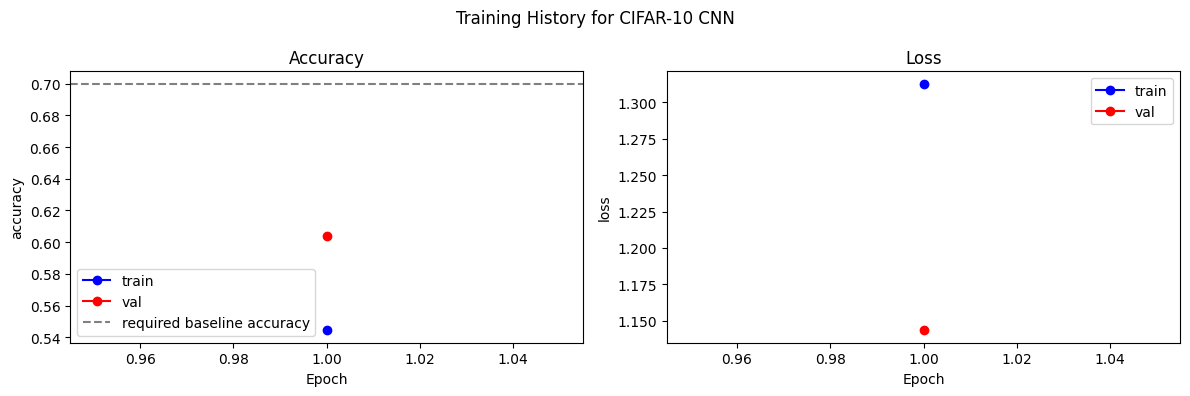

(<Figure size 1200x400 with 2 Axes>,
 array([<Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='loss'>],
       dtype=object))

In [6]:
def plot_training_history(history=None, figsize=(12, 4), suptitle=None, save_path=None):
    """
    Plot training/validation accuracy and loss per epoch.
    If `history` is None, uses the notebook variable `history` if present.
    Returns (fig, axes).
    """
    if history is None:
        history = globals().get("history")
        if history is None:
            raise ValueError("No history provided and no global 'history' found.")
    # accept either Keras History object or a plain dict
    h = history.history if hasattr(history, "history") else history

    # determine number of epochs
    first_series = next(iter(h.values()))
    epochs = range(1, len(first_series) + 1)

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Accuracy plot (handles both "accuracy" and legacy "acc")
    acc_key = "accuracy" if "accuracy" in h else ("acc" if "acc" in h else None)
    axes[0].plot(epochs, h[acc_key], "bo-", label="train")
    val_acc_key = "val_" + acc_key
    if val_acc_key in h:
        axes[0].plot(epochs, h[val_acc_key], "ro-", label="val")

    axes[0].axhline(y=0.7, color="gray", linestyle="--", label="required baseline accuracy")
    axes[0].set_title("Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel(acc_key)
    axes[0].legend()

    # Loss plot
    axes[1].plot(epochs, h["loss"], "bo-", label="train")
    if "val_loss" in h:
        axes[1].plot(epochs, h["val_loss"], "ro-", label="val")
    axes[1].set_title("Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("loss")
    axes[1].legend()

    if suptitle:
        fig.suptitle(suptitle)
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches="tight")

    plt.show()
    return fig, axes

plot_training_history(history, suptitle="Training History for CIFAR-10 CNN")

In [7]:
# model.save("base_model.keras")